<a href="https://colab.research.google.com/github/ewapajak/ML/blob/main/homework02_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: EM Clustering in 2D**


### **How can we visualize the *decision boundary* for attributing a *new* (unlabeled) point to one of the GMM clusters?**

In other words, given a 2D data distribution modeled by EM, think of a way to clearly show (on a plot) *which* cluster a point would be assigned to (or which cluster has the highest responsibility (posterior probability) for that point)?  

##Decision boundary

The dataset used for this visualization is the mouse dataset from class. To better understand to which cluster a new point should be assigned, I will use a meshgrid to visualize the decision boundaries.

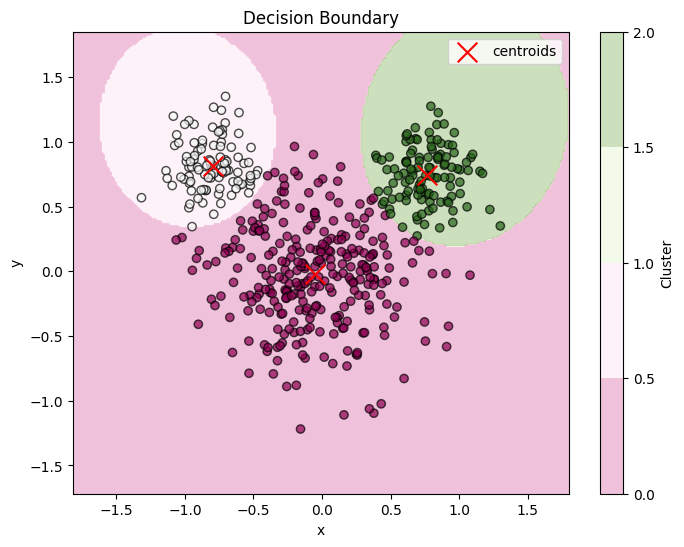

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import matplotlib.colors as mcolors

#Generating the 'mouse' dataset:

np.random.seed(0)  # for reproducibility

# 1) 300 points from N([0, 0], [[0.16, 0],[0, 0.16]])
mean1 = np.array([0.0, 0.0])
cov1 = np.array([[0.16, 0.0],
                 [0.0,  0.16]])
data1 = np.random.multivariate_normal(mean1, cov1, 300)

# 2) 100 points from N([0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean2 = np.array([0.8, 0.8])
cov2 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data2 = np.random.multivariate_normal(mean2, cov2, 100)

# 3) 100 points from N([-0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean3 = np.array([-0.8, 0.8])
cov3 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data3 = np.random.multivariate_normal(mean3, cov3, 100)

# Combine all data
data_X = np.vstack([data1, data2, data3])
N, d = data_X.shape  # should be (500, 2)

#GMM
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
gmm.fit(data_X)

#meshgrid
x_min, x_max = data_X[:, 0].min() - 0.5, data_X[:, 0].max() + 0.5
y_min, y_max = data_X[:, 1].min() - 0.5, data_X[:, 1].max() + 0.5
xx,yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

Z = gmm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#plot
plt.figure(figsize= (8,6))
contour = plt.contourf(xx,yy, Z, levels=3, cmap = 'PiYG', alpha = 0.3)
plt.scatter(data_X[:,0], data_X[:,1], c = gmm.predict(data_X), cmap = 'PiYG', edgecolors = 'k', alpha = 0.7)
plt.scatter(gmm.means_[:,0], gmm.means_[:, 1], c = "red", marker = "x", s = 200, label = "centroids")
cbar = plt.colorbar(contour)
cbar.set_label("Cluster")
plt.title("Decision Boundary")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

plt.show()


Our meshgrid separated our clusters effectively, making it obvious where to classify a new (unlabeled) point. For almost every given point its cluster can be identified by the background colour. There are few points located on or close to the decision boundaries. Ellipsoidal decision regions alligns well with the fact that our data comes from Gaussion distributons.
The irregularity that we can observe is that only one decision region (of cluster nr 0) accounts for almost the entire plane. This behaviour can be explained by the highest variance of cluster 0.

###**If we *didn't know* the number of clusters in advance, how could we decide on a suitable $K$ for the clustering algorithm?**  

You can illustrate your approach with **the same** dataset as in the primary question by trying different values of $K$ (and optionally plotting the evaluation metric values, e.g. silhouette scores, etc.). Or you can find another suitable dataset, it's up to you. Note, that the dataset doesn't need to be 2D in this task.

In this part, I will evaluate metrics mentioned in our class for different values $K$ in order to determine a suitable value for the clustering algorithm. Again, I will use the 'mouse' dataset.

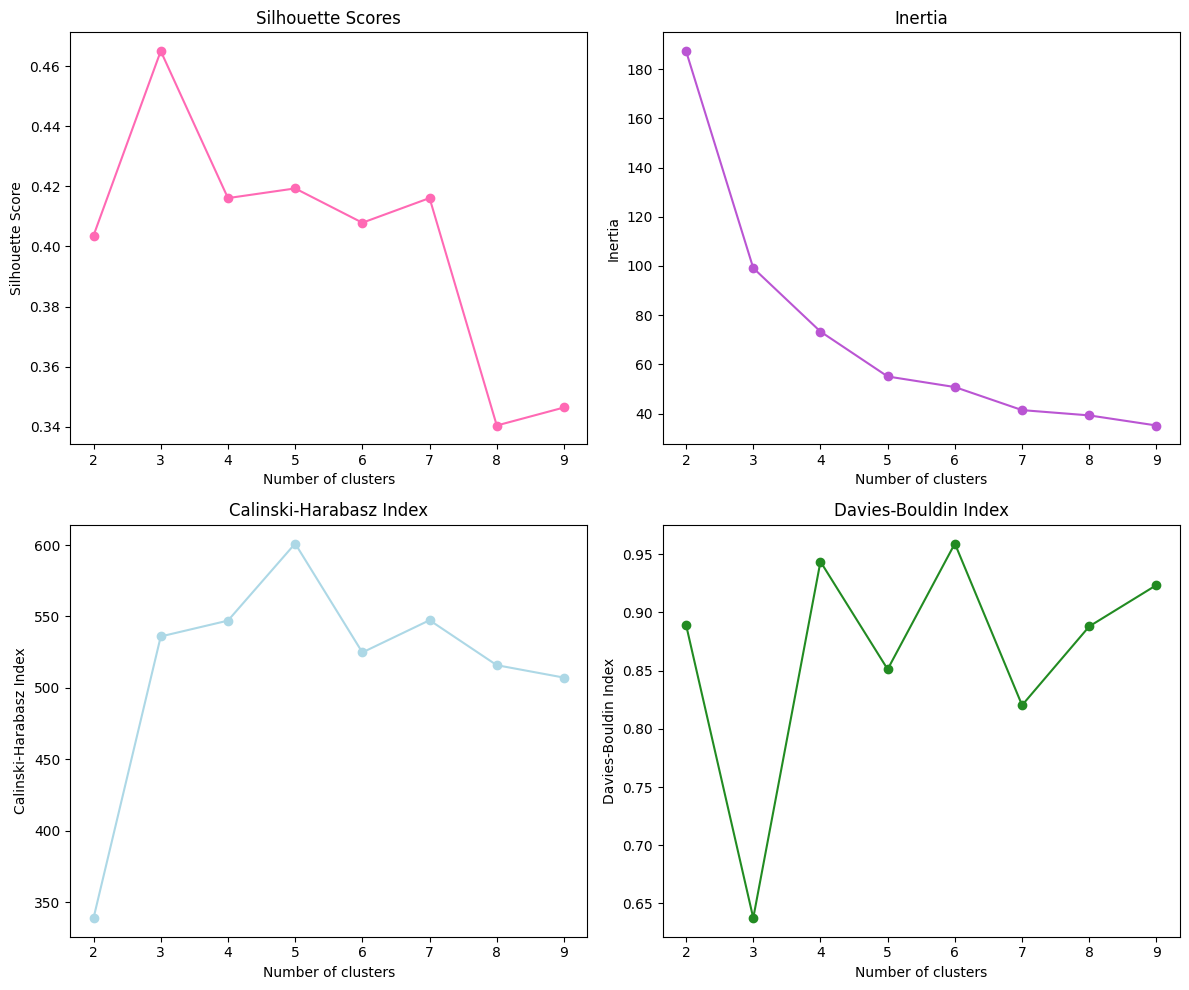

In [42]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score,davies_bouldin_score
from scipy.spatial.distance import cdist

K_val = range(2,10)
silhouette_scores = []
inertia_scores = []
calinski_scores = []
davies_scores = []


for k in K_val:
  gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
  labels = gmm.fit_predict(data_X)
  inertia = sum( [np.linalg.norm(data_X[i] -gmm.means_[labels[i]])**2 for i in range(len(data_X)) ])
  inertia_scores.append(inertia)
  silhouette_scores.append(silhouette_score(data_X, labels))
  calinski_scores.append(calinski_harabasz_score(data_X, labels))
  davies_scores.append(davies_bouldin_score(data_X, labels))

fig, axes = plt.subplots(2,2, figsize = (12,10))
axes = axes.ravel()
axes[0].plot(K_val, silhouette_scores, marker = "o", linestyle = '-', color = 'hotpink')
axes[0].set_title('Silhouette Scores')
axes[0].set_xlabel("Number of clusters")
axes[0].set_ylabel("Silhouette Score")

axes[1].plot(K_val, inertia_scores, marker = "o", linestyle = '-', color = 'mediumorchid')
axes[1].set_title('Inertia')
axes[1].set_xlabel("Number of clusters")
axes[1].set_ylabel("Inertia")


axes[2].plot(K_val, calinski_scores, marker = "o", linestyle = '-', color = 'lightblue')
axes[2].set_title('Calinski-Harabasz Index')
axes[2].set_xlabel("Number of clusters")
axes[2].set_ylabel("Calinski-Harabasz Index")

axes[3].plot(K_val, davies_scores, marker = "o", linestyle = '-', color = 'forestgreen')
axes[3].set_title('Davies-Bouldin Index')
axes[3].set_xlabel("Number of clusters")
axes[3].set_ylabel("Davies-Bouldin Index")


plt.tight_layout()
plt.show()


The highest silhouette score for $K = 3$ suggests well-separated clusters. We can observe that the more clusters, the more compact and tighter they become (lower inertia). Lower index values for the Davies-Boulding Index indicate a better clustering result: increased separation between clusters and decreased variation within clusters. Again, we observe the lowest Davies-Bouldin Index for $K=3$. A higher value of Calinski-Harabasz Index indicates a better clustering, because it means that the data points are more spread out between clusters than they are within clusters.
All metrics strongly suggest that $K = 3$ is the optimal choice.